# Parameter fitting the Roche Model

## Generating epiabm data

In [19]:
import pyEpiabm as pe
import epimodels as em
import pandas as pd
import pints
# Load necessary libraries
import numpy as np
import epimodels as em
import matplotlib
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten
from plotnine import ggplot, aes, geom_line, labs, theme_minimal

ModuleNotFoundError: No module named 'plotnine'

In [13]:
# Populate the model
regions = ['Luxembourg']
age_groups = ['0-10', '10-25']

# Initial state of the system
contact_data_matrix_0 = np.array([[10, 5.2], [0, 3]])


region_data_matrix_0_0 = np.array([[1, 10], [1, 6]])

contacts_0 = em.ContactMatrix(age_groups, contact_data_matrix_0)


regional_0_0 = em.RegionMatrix(
    regions[0], age_groups, region_data_matrix_0_0)

# Matrices contact
matrices_contact = [contacts_0]
time_changes_contact = [1]
matrices_region = [
    [regional_0_0]]
time_changes_region = [1]

# NPIs data
max_levels_npi = [3, 3, 2, 4, 2, 3, 2, 4, 2]
targeted_npi = [True, True, True, True, True, True, True, False, True]
general_npi = [
    [True, False, True, True, False, False, False, False, False],
    [True, False, True, True, True, True, False, False, False]]
time_changes_flag = [1, 12]

reg_levels_npi = [
    [[0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 3, 2, 4, 2, 3, 2, 4, 2]]]
time_changes_npi = [1, 14]

In [15]:
# Instantiate model
model = em.RocheSEIRModel()

# Set the region names, contact and regional data of the model
model.set_regions(regions)
model.set_age_groups(age_groups)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)
model.read_npis_data(max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag)

# Set ICs parameters
ICs = em.RocheICs(
    model=model,
    susceptibles_IC=[[1500, 600]],
    exposed_IC=[[0, 0]],
    infectives_pre_IC=[[40, 20]],
    infectives_asym_IC=[[0, 10]],
    infectives_sym_IC=[[10, 20]],
    infectives_pre_ss_IC=[[2, 3]],
    infectives_asym_ss_IC=[[1, 1]],
    infectives_sym_ss_IC=[[4, 5]],
    infectives_q_IC=[[0, 0]],
    recovered_IC=[[0, 0]],
    recovered_asym_IC=[[0, 0]],
    dead_IC=[[0, 0]]
)

# Set average times in compartments
compartment_times = em.RocheCompartmentTimes(
    model=model,
    k=3.43,
    kS=2.57,
    kQ=1,
    kR=9 * np.ones(len(age_groups)),
    kRI=10 * np.ones(len(age_groups))
)

# Set proportion of asymptomatic, super-spreader and dead cases
proportion_parameters = em.RocheProportions(
    model=model,
    Pa=0.658 * np.ones(len(age_groups)),
    Pss=0.0955,
    Pd=0.05 * np.ones(len(age_groups))
)

# Set transmission parameters
transmission_parameters = em.RocheTransmission(
    model=model,
    beta_min=0.228,
    beta_max=0.927,
    bss=3.11,
    gamma=1,
    s50=35.3
)

# Set other simulation parameters
simulation_parameters = em.RocheSimParameters(
    model=model,
    region_index=1,
    method='RK45',
    times=np.arange(1, 20.5, 0.5).tolist()
)

# Set all parameters in the controller
parameters = em.RocheParametersController(
    model=model,
    ICs=ICs,
    compartment_times=compartment_times,
    proportion_parameters=proportion_parameters,
    transmission_parameters=transmission_parameters,
    simulation_parameters=simulation_parameters
)

In [16]:
# Simulate for the single region
parameters.simulation_parameters.region_index = 0  # Since there's only one region

# Simulate using the ODE solver
output = model.simulate(parameters)


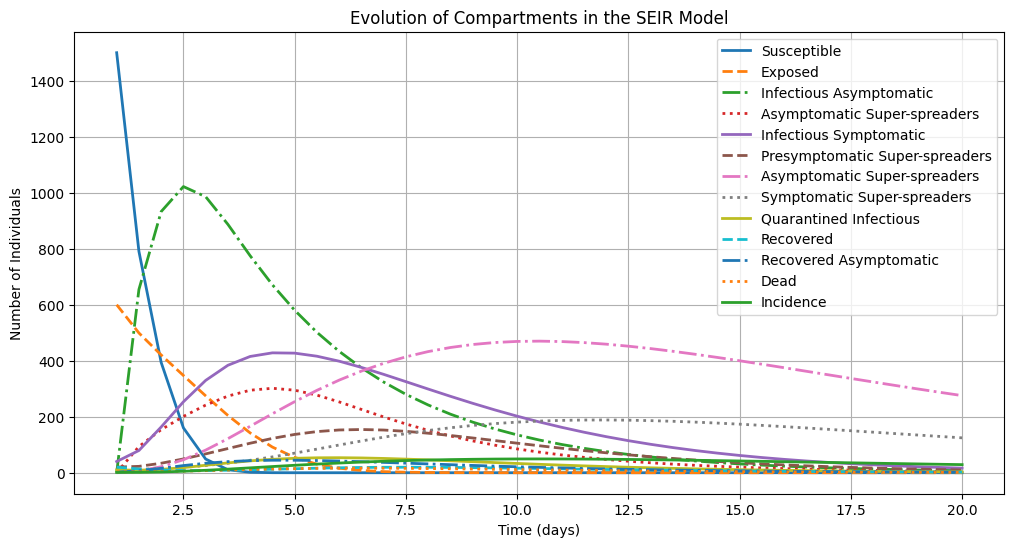

In [17]:
# Define compartments based on the RocheSEIRModel output structure
time_steps = np.array(parameters.simulation_parameters.times)

# Extract compartments
S = output[:, 0]   # Susceptible
E = output[:, 1]   # Exposed
Ia = output[:, 2]  # Asymptomatic infectious
Iaa = output[:, 3] # Asymptomatic super-spreaders
Is = output[:, 4]  # Symptomatic infectious
Ias = output[:, 5] # Presymptomatic super-spreaders
Iaas = output[:, 6] # Asymptomatic super-spreaders
Iss = output[:, 7] # Symptomatic super-spreaders
Iq = output[:, 8]  # Quarantined infectious
R = output[:, 9]   # Recovered
Ra = output[:, 10] # Recovered asymptomatic
D = output[:, 11]  # Dead
Inc = output[:, 12] # Incidence (new cases per time step)

# Plot all compartments on the same graph
plt.figure(figsize=(12, 6))

plt.plot(time_steps, S, label='Susceptible', linestyle='-', linewidth=2)
plt.plot(time_steps, E, label='Exposed', linestyle='--', linewidth=2)
plt.plot(time_steps, Ia, label='Infectious Asymptomatic', linestyle='-.', linewidth=2)
plt.plot(time_steps, Iaa, label='Asymptomatic Super-spreaders', linestyle=':', linewidth=2)
plt.plot(time_steps, Is, label='Infectious Symptomatic', linestyle='-', linewidth=2)
plt.plot(time_steps, Ias, label='Presymptomatic Super-spreaders', linestyle='--', linewidth=2)
plt.plot(time_steps, Iaas, label='Asymptomatic Super-spreaders', linestyle='-.', linewidth=2)
plt.plot(time_steps, Iss, label='Symptomatic Super-spreaders', linestyle=':', linewidth=2)
plt.plot(time_steps, Iq, label='Quarantined Infectious', linestyle='-', linewidth=2)
plt.plot(time_steps, R, label='Recovered', linestyle='--', linewidth=2)
plt.plot(time_steps, Ra, label='Recovered Asymptomatic', linestyle='-.', linewidth=2)
plt.plot(time_steps, D, label='Dead', linestyle=':', linewidth=2)
plt.plot(time_steps, Inc, label='Incidence', linestyle='-', linewidth=2)

# Labels and title
plt.xlabel('Time (days)')
plt.ylabel('Number of Individuals')
plt.title('Evolution of Compartments in the SEIR Model')
plt.legend(loc='upper right', fontsize=10)
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
roche_model=em.RocheSEIRModel()
data=pd.read_csv("simulation_outputs/output_gibraltar.csv")

# Drop unnecessary columns
df = df.drop(columns=["age_group", "cell", "location_x", "location_y"], errors="ignore")

# Aggregate by time while keeping "time" as a column
df_agg = df.groupby("time", as_index=False).sum()

# Add total incidence column
df_agg["Total Incidence"] = df_agg.drop(columns=["time"]).sum(axis=1)

print(df_agg["time"])

print(roche_model.n_parameters())
times=df_agg['time'].values
values = df_agg["InfectionStatus.Dead"].values

problem = pints.MultiOutputProblem(roche_model, times, values)

0      0.0
1      1.0
2      2.0
3      3.0
4      4.0
      ... 
86    86.0
87    87.0
88    88.0
89    89.0
90    90.0
Name: time, Length: 91, dtype: float64
25


ValueError: Values array must have shape `(n_times, n_outputs)`.

In [ ]:
# Load the dataset
df=pd.read_csv("simulation_outputs/output_gibraltar.csv")

# Extract total infected cases
df['total_infected'] = (df['InfectionStatus.Exposed'] + df['InfectionStatus.InfectMild'] +
                        df['InfectionStatus.InfectGP'] + df['InfectionStatus.InfectHosp'] +
                        df['InfectionStatus.InfectICU'])

# Extract time and infected cases
times = df['time'].values
infected_data = df['total_infected'].values

# Define SEIR model as a PINTS ForwardModel
class SEIRModel(em.RocheSEIRModel):
    def __init__(self):
        super(SEIRModel, self).__init__()
    
    def simulate(self, parameters, times):
        beta, sigma, gamma = parameters  # Transmission, incubation, recovery rates
        S, E, I, R = [0.99], [0.01], [0.0], [0.0]  # Initial conditions

        dt = np.mean(np.diff(times))  # Time step
        for _ in times[1:]:
            S_new = S[-1] - beta * S[-1] * I[-1] * dt
            E_new = E[-1] + beta * S[-1] * I[-1] * dt - sigma * E[-1] * dt
            I_new = I[-1] + sigma * E[-1] * dt - gamma * I[-1] * dt
            R_new = R[-1] + gamma * I[-1] * dt

            S.append(S_new)
            E.append(E_new)
            I.append(I_new)
            R.append(R_new)

        return np.array(I)  # Return only infected population for fitting

    def n_parameters(self):
        return 3  # beta, sigma, gamma

# Instantiate the model
seir_model = SEIRModel()

# Create PINTS problem
problem = pints.SingleOutputProblem(seir_model, times, infected_data)
error_measure = pints.SumOfSquaresError(problem)

# Initial parameter guesses: [beta, sigma, gamma]
initial_params = [0.5, 0.2, 0.1]

# Set parameter bounds
lower_bounds = [0.0, 0.0, 0.0]
upper_bounds = [2.0, 1.0, 1.0]

# Optimization setup
optimizer = pints.OptimisationController(
    error_measure, 
    x0=initial_params, 
    method=pints.CMAES, 
    boundaries=pints.RectangularBoundaries(lower_bounds, upper_bounds)
)
optimizer.set_max_iterations(1000)

# Run optimization
estimated_params, _ = optimizer.run()
print(f"Estimated Parameters: beta={estimated_params[0]:.4f}, sigma={estimated_params[1]:.4f}, gamma={estimated_params[2]:.4f}")

# Simulate with estimated parameters
fitted_infected = seir_model.simulate(estimated_params, times)

# Plot results
plt.figure(figsize=(10, 5))
plt.plot(times, infected_data, 'bo', label='Observed Infected Cases', alpha=0.5)
plt.plot(times, fitted_infected, 'r-', label='SEIR Model Fit')
plt.xlabel('Time')
plt.ylabel('Infected Population')
plt.legend()
plt.title('SEIR Model Parameter Estimation for Gibraltar Data')
plt.show()

ValueError: Only single-output models can be used for a SingleOutputProblem.